<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Blob by probability distribution fuction (PDFs) </b></span><br>
<span style="font-size: 16px;">
- Spectral analysis of blobs is often used to show the intermittency of blobs. <br>
- Skewness, Kurtosis might be different between NT and PT<br>
- The interpretation of positive and negative Skewness/Kurtosis is explained in my Evernote
</span>
</div>



In [2]:
import sys
sys.path.append('/marconi/home/userexternal/klim0000/my_venv/lib/python3.9/site-packages')
#from skimage.measure import label, regionprops

In [3]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

from skimage import measure
from scipy.stats import gaussian_kde
from scipy.stats import skew, kurtosis



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# IEEE journals typically require figures to be very clear at a column width of around 3.5 to 4 inches
fig_width = 3.5  # in inches
fig_height =  fig_width / 1.618
plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (fig_width, fig_width / 1.618),  # IEEE column width, golden ratio height
    'figure.dpi': 300,                     # Figure resolution
    'savefig.dpi': 300,                    # Save figure resolution
    'savefig.format': 'pdf',               # Preferred format for vector graphics

    # Font settings
    'font.size': 10,                       # Main font size
    'font.family': 'Sans-serif',           # Font family
    'font.sans-serif': ['Arial', 'Helvetica'],  # Font type

    # Axes settings
    'axes.labelsize': 10,                  # Font size of the x and y labels
    'axes.titlesize': 10,                  # Font size of the title
    'axes.linewidth': 1,                   # Edge line width

    # Tick settings
    'xtick.labelsize': 10,                  # Font size of the x tick labels
    'ytick.labelsize': 10,                  # Font size of the y tick labels
    'xtick.major.size': 4,                 # Length of major tick marks
    'xtick.minor.size': 2,                 # Length of minor tick marks
    'xtick.major.width': 1,                # Width of major tick marks
    'xtick.minor.width': 0.5,              # Width of minor tick marks
    'ytick.major.size': 4,                 # Length of major tick marks
    'ytick.minor.size': 2,                 # Length of minor tick marks
    'ytick.major.width': 1,                # Width of major tick marks
    'ytick.minor.width': 0.5,              # Width of minor tick marks

    # Legend settings
    'legend.fontsize': 12,                  # Font size of the legend
    'legend.frameon': True,               # Disable background frame
    'legend.edgecolor':'white',

    # Line settings
    'lines.linewidth': 1.5,                # Line width
    'lines.markersize': 4,                 # Marker size
    'lines.markeredgewidth' : 0.8,
    'lines.markeredgecolor' : 'black',
    # Grid settings
    'grid.alpha': 0.5,                     # Grid line transparency
    'grid.linestyle': ':',                 # Grid line style
    
    # Scatter settings
    'scatter.edgecolors': None,
    
    # Marker
    'lines.markeredgewidth' : 5,
    'lines.markeredgecolor' : 'black'

})

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Read DN + NT dataset </b></span><br>
</div>

In [5]:
# Get the current working directory|
cwd = os.getcwd()

# nu-scan
os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/delta_scan/DNT_dn0p6')

# st-scan

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Current working directory: /marconi/home/userexternal/klim0000/jupyter_notebook/3_GBS_DN_Tria


In [7]:
t2= s.time[-1]
t1= t2 -10

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]


dens  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_avg_tor = np.mean(dens, axis=2)

dens_fluct_avg_NT=[]
for i in range(len(dens[0,0,0,:])):
    dens_fluct_NT   = np.sqrt((dens[:,:,0,i]-dens_avg_tor[:,:,i])**2) / dens_avg_tor[:,:,i]
    dens_fluct_avg_NT.append(dens_fluct_NT)

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>PDF in three different regions</b></span><br>
<span style="font-size: 16px;">
- (1) Core (2) Near SOL (3) Far SOL <br>
- Let's first find the index of each points 
</span>
</div>



In [8]:
ix_core, iy_core = [s.ix0, s.iy0]
ix_near_SOL, iy_near_SOL = [175, s.iy0]
ix_far_SOL,  iy_far_SOL = [200, s.iy0]

findfont: Font family ['Sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica


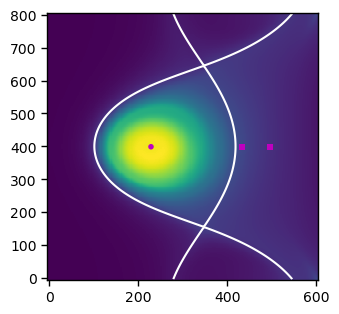

In [9]:
fig, ax = plt.subplots(figsize=(fig_width, 1.6*fig_height), dpi=100)
X, Y = np.meshgrid(s.x, s.y)
ax.pcolormesh(X, Y, dens_avg)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='w')
ax.scatter(x=s.x0, y=s.y0, c='m') # Core regoin
ax.scatter(x=s.x[ix_near_SOL], y=s.y[iy_near_SOL], c='m', marker='s') # Near SOL
ax.scatter(x=s.x[ix_far_SOL], y=s.y[iy_far_SOL], c='m', marker='s') # Far SOL


plt.show()

In [10]:
dens_fluct_core = []
dens_fluct_near_SOL = []
dens_fluct_far_SOL = []
for i in range(len(dens_fluct_avg_NT)):
    dens_fluct_core.append(dens_fluct_avg_NT[i][iy_core][ix_core])
    dens_fluct_near_SOL.append(dens_fluct_avg_NT[i][iy_near_SOL][ix_near_SOL])
    dens_fluct_far_SOL.append(dens_fluct_avg_NT[i][iy_far_SOL][ix_far_SOL])

# Normalized
data_core = (dens_fluct_core - np.mean(dens_fluct_core)) / np.std(dens_fluct_core)
data_near_SOL = (dens_fluct_near_SOL - np.mean(dens_fluct_near_SOL)) / np.std(dens_fluct_near_SOL)
data_far_SOL = (dens_fluct_far_SOL - np.mean(dens_fluct_far_SOL)) / np.std(dens_fluct_far_SOL)

# Not Normalized
#data_core = dens_fluct_core
#data_near_SOL = dens_fluct_near_SOL
#data_far_SOL = dens_fluct_far_SOL

    
kde_core = gaussian_kde(data_core)
kde_near_SOL = gaussian_kde(data_near_SOL)
kde_far_SOL  = gaussian_kde(data_far_SOL)

x_grid_core = np.linspace(min(data_core), max(data_core), 1000)
x_grid_near_SOL = np.linspace(min(data_near_SOL), max(data_near_SOL), 1000)
x_grid_far_SOL = np.linspace(min(data_far_SOL), max(data_far_SOL), 1000)

PDF_core = kde_core.evaluate(x_grid_core)
PDF_near_SOL = kde_near_SOL.evaluate(x_grid_near_SOL)
PDF_far_SOL = kde_far_SOL.evaluate(x_grid_far_SOL)

kurtosis_core = kurtosis(data_core)
skewness_core = skew(data_core)

kurtosis_near_SOL = kurtosis(data_near_SOL)
skewness_near_SOL = skew(data_near_SOL)

kurtosis_far_SOL = kurtosis(data_far_SOL)
skewness_far_SOL = skew(data_far_SOL)

print(kurtosis_core, kurtosis_near_SOL, kurtosis_far_SOL)
print(skewness_core, skewness_near_SOL, skewness_far_SOL)

-0.9528560773633936 -0.3657429784818991 0.4394228245690299
0.31484343585989116 0.43205523299773274 0.978100094306038


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b> What the values of kurtosis and skewness represent physically? </b></span><br>
    
    
<span style="font-size: 16px;">
- Kurtosis close to 0 = distribution is similar to the Gaussian distribution <br>
- Positive Kurtosis = this indicates a distribution with heavier tails than Gaussian PDF. This represents a higher chance of extreme values.<br>
- Negative Kurtosis = This means that extreme values are less likely than they would be in a Gaussian distribution
</span><br>
    
    
<span style="font-size: 26px;"><b> Skewness </b></span><br>
<span style="font-size: 16px;">
- Skewness close to 0 = the data is symmetrically distributed <br>
- Positive Skewness = the distribution is skewed to the right, meaning that there is a longer tail. For blobs, thie means that while the majority of blobs are close to the mean value, there is a higher chance that to obtain blobs with much higher values. <br>
- Negative Skewness = negatively skewed, highcer chance to detect extremely low amplitude blobs
</span>
    
</div>



Text(0.5, 1.0, 'Far SOL')

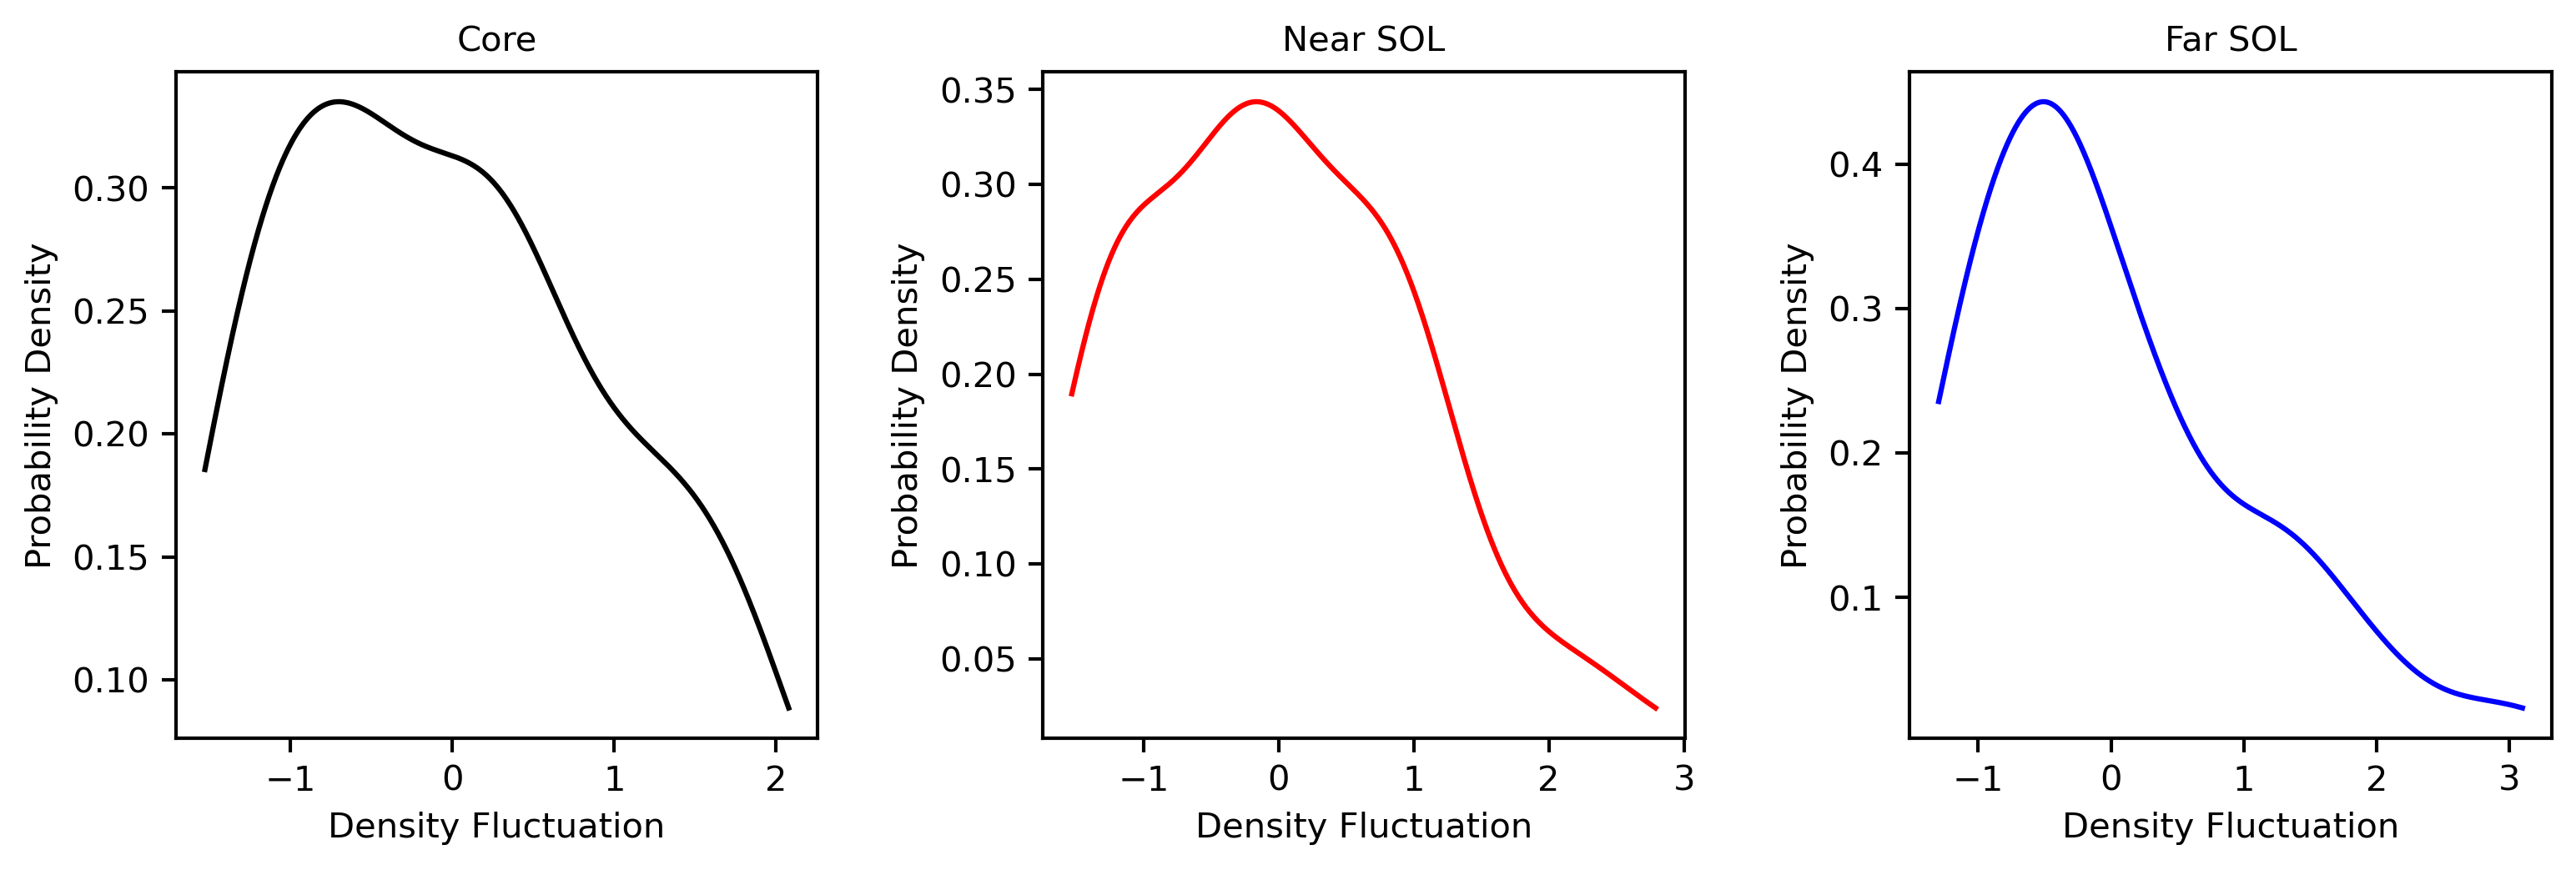

In [11]:
# Plotting PDFs
#plt.subfigure(ncols=3, figsize=(10, 7), dpi=100)
fig, axes = plt.subplots(ncols=3, figsize=(3.5*fig_width, 1.6*fig_height))

axes[0].plot(x_grid_core, PDF_core, c='k', label='Core')
axes[1].plot(x_grid_near_SOL, PDF_near_SOL, c='r', label='Near SOL')
axes[2].plot(x_grid_far_SOL, PDF_far_SOL, c='b', label='Far SOL')
#plot_pdf(dens_fluct_far_SOL, 'Far SOL')

for ax in axes:
    ax.set_xlabel('Density Fluctuation')
    ax.set_ylabel('Probability Density')

axes[0].set_title('Core')
axes[1].set_title('Near SOL')
axes[2].set_title('Far SOL')
#plt.legend()
#plt.title('Density Fluctuation PDFs')
#plt.show()

findfont: Font family ['Sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica


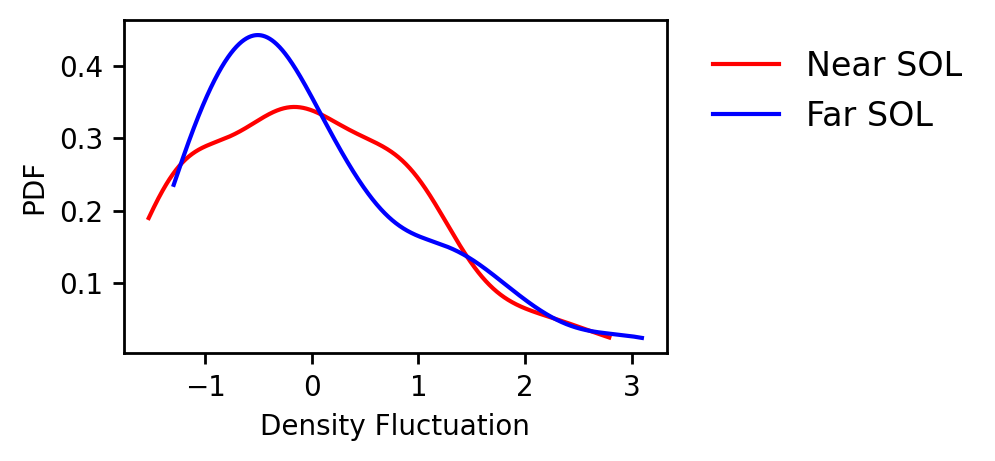

In [12]:
# Plotting PDFs
#plt.subfigure(ncols=3, figsize=(10, 7), dpi=100)
fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200)

#axes.plot(x_grid_core, PDF_core, c='k', label='Core')
axes.plot(x_grid_near_SOL, PDF_near_SOL, c='r', label='Near SOL')
axes.plot(x_grid_far_SOL, PDF_far_SOL, c='b', label='Far SOL')
#plot_pdf(dens_fluct_far_SOL, 'Far SOL')

axes.set_xlabel('Density Fluctuation')
axes.set_ylabel('PDF')

#axes.set_title('PDF')

axes.legend(bbox_to_anchor=(1.6, 1), loc='upper right', facecolor='white', framealpha=0)
#plt.legend()

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b> Comparison between PT and NT </b></span><br>
</div>

<div class="alert alert-block alert-info">
<span style="font-size: 14px;"><b> NT read </b></span><br>
</div>

In [15]:
# NT 
os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/delta_scan/DNT_dn0p6')

# Load GBS simulations
s=g.Sim()

t2= s.time[-1]
t1= t2 -10

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

# Index core region
ix0_NT = s.ix0; iy0_NT = s.iy0
Psi_NT = s.Psi
ixxpt_NT = s.ixxpt; iyxpt_NT = s.iyxpt

dens_NT  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg_NT  = np.mean(dens_NT, axis=(2,3)); 
dens_avg_tor_NT = np.mean(dens_NT, axis=2)

dens_fluct_avg_NT=[]

for i in range(len(dens_NT[0,0,0,:])):
    dens_fluct_NT   = np.sqrt((dens_NT[:,:,0,i]-dens_avg_tor_NT[:,:,i])**2) / dens_avg_tor_NT[:,:,i]
    dens_fluct_avg_NT.append(dens_fluct_NT)

<div class="alert alert-block alert-info">
<span style="font-size: 14px;"><b> PT read </b></span><br>
</div>

In [32]:
#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

# Get the current working directory|
cwd = os.getcwd()

# NT 
os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/delta_scan/DPT_d0p6')

# Load GBS simulations
s=g.Sim()

t2= s.time[-1]
t1= t2 -10

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

ix0_PT = s.ix0; iy0_PT = s.iy0
Psi_PT = s.Psi
ixxpt_PT = s.ixxpt; iyxpt_PT = s.iyxpt

dens_PT  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg_PT  = np.mean(dens_PT, axis=(2,3)); 
dens_avg_tor_PT = np.mean(dens_PT, axis=2)

dens_fluct_avg_PT=[]
for i in range(len(dens_PT[0,0,0,:])):
    dens_fluct_PT   = np.sqrt((dens_PT[:,:,0,i]-dens_avg_tor_PT[:,:,i])**2) / dens_avg_tor_PT[:,:,i]
    dens_fluct_avg_PT.append(dens_fluct_PT)

In [35]:
# NT indexes

ix_core_NT,     iy_core_NT = [ix0_NT, iy0_NT]
ix_near_SOL_NT, iy_near_SOL_NT = [175, iy0_NT]
ix_far_SOL_NT,  iy_far_SOL_NT = [220, iy0_NT]

# PT indexes

ix_core_PT,     iy_core_PT = [ix0_PT, iy0_PT]
ix_near_SOL_PT, iy_near_SOL_PT = [210, iy0_PT]
ix_far_SOL_PT,  iy_far_SOL_PT = [228, iy0_PT]
#ix_far_SOL_PT,  iy_far_SOL_PT = [160, iy0_PT]

<div class="alert alert-block alert-info">
<span style="font-size: 14px;"><b> Find indexes of near/far SOL in NT and PT cases </b></span><br>
</div>

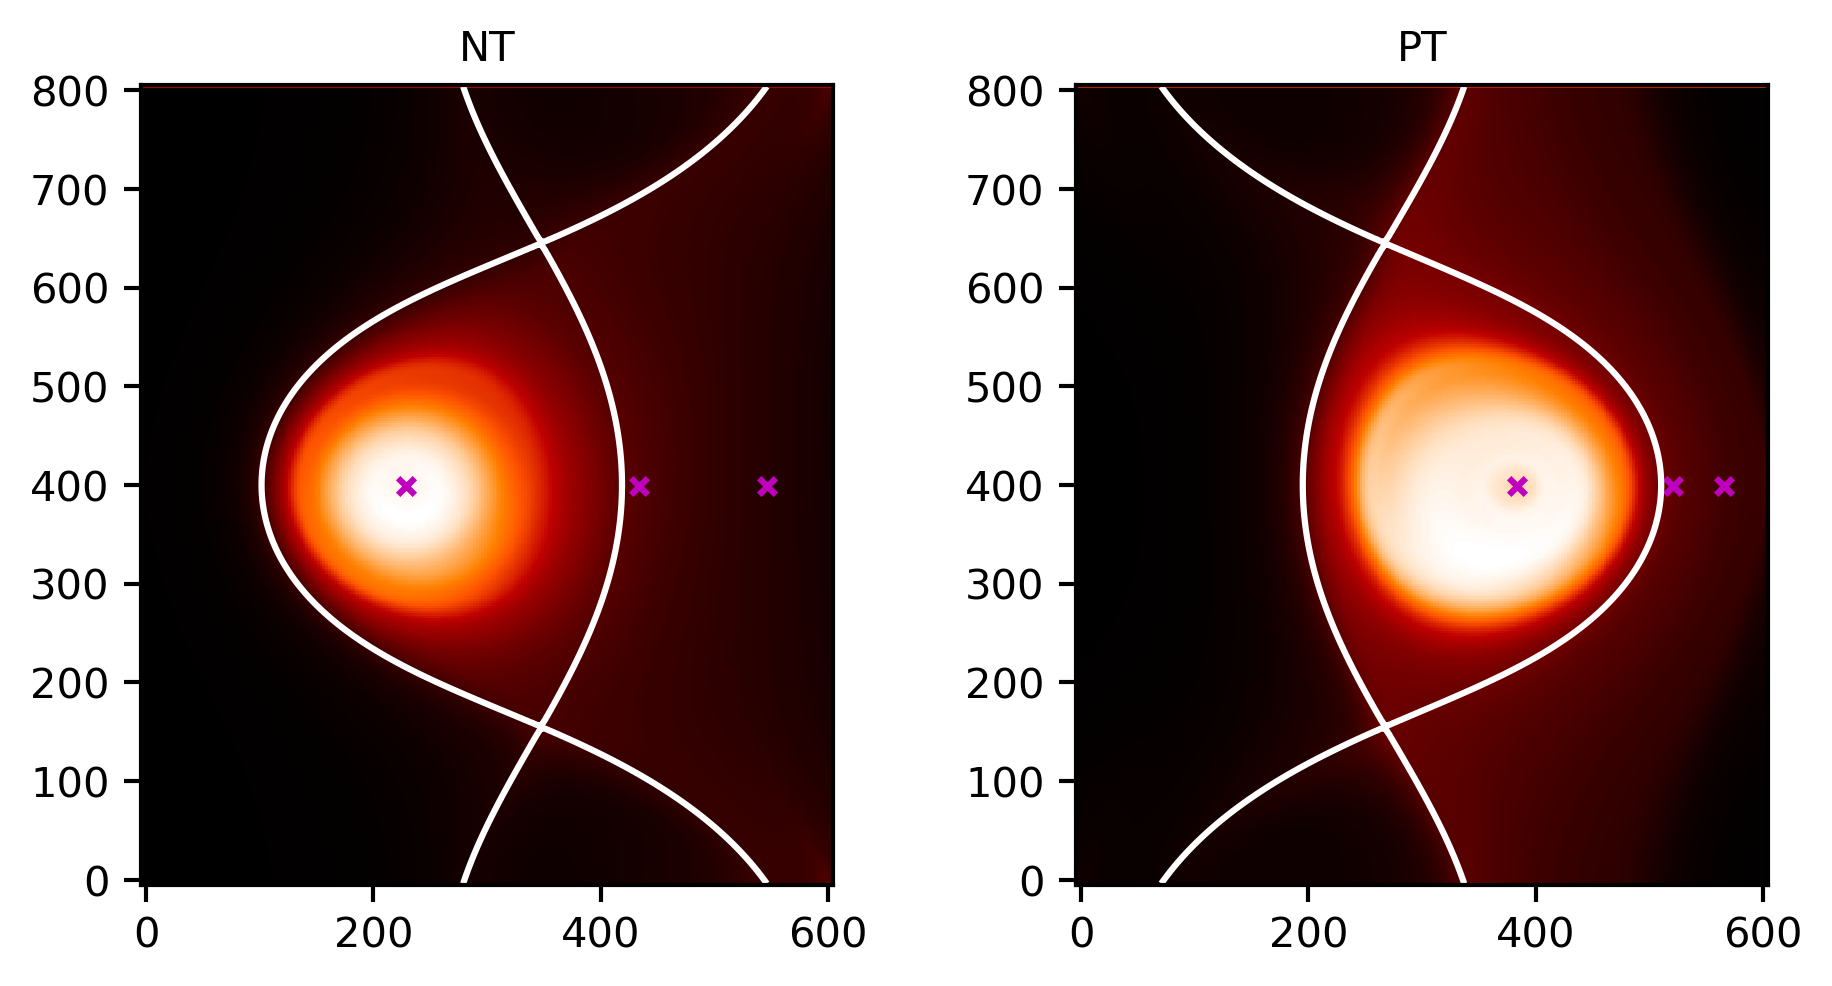

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(2*fig_width, 1.6*fig_height))
X, Y = np.meshgrid(s.x, s.y)
axes[0].pcolormesh(X, Y, dens_avg_NT, cmap='gist_heat')
axes[0].contour(X, Y, Psi_NT, levels=[Psi_NT[iyxpt_NT, ixxpt_NT]], colors='w')
axes[0].scatter(x=s.x[ix_core_NT], y=s.y[iy_core_NT], c='m', marker='x') # Core regoin
axes[0].scatter(x=s.x[ix_near_SOL_NT], y=s.y[iy_near_SOL_NT], c='m', marker='x') # Near SOL
axes[0].scatter(x=s.x[ix_far_SOL_NT], y=s.y[iy_far_SOL_NT], c='m', marker='x') # Far SOL
axes[0].set_title('NT')

axes[1].pcolormesh(X, Y, dens_avg_PT, cmap='gist_heat')
axes[1].contour(X, Y, Psi_PT, levels=[Psi_PT[iyxpt_PT, ixxpt_PT]], colors='w')
axes[1].scatter(x=s.x[ix_core_PT], y=s.y[iy_core_PT], c='m', marker='x') # Core regoin
axes[1].scatter(x=s.x[ix_near_SOL_PT], y=s.y[iy_near_SOL_PT], c='m', marker='x') # Near SOL
axes[1].scatter(x=s.x[ix_far_SOL_PT], y=s.y[iy_far_SOL_PT], c='m', marker='x') # Far SOL
axes[1].set_title('PT')


plt.show()

<div class="alert alert-block alert-info">
<span style="font-size: 18px;"><b> Compute PDF </b></span><br>
</div>

In [38]:
NT_dens_fluct_core = []
NT_dens_fluct_near_SOL = []
NT_dens_fluct_far_SOL = []
for i in range(len(dens_fluct_avg_NT)):
    NT_dens_fluct_core.append(dens_fluct_avg_NT[i][iy_core_NT][ix_core_NT])
    NT_dens_fluct_near_SOL.append(dens_fluct_avg_NT[i][iy_near_SOL_NT][ix_near_SOL_NT])
    NT_dens_fluct_far_SOL.append(dens_fluct_avg_NT[i][iy_far_SOL_NT][ix_far_SOL_NT])

# Normalized
#NT_data_core = (NT_dens_fluct_core - np.mean(NT_dens_fluct_core)) / np.std(NT_dens_fluct_core)
#NT_data_near_SOL = (NT_dens_fluct_near_SOL - np.mean(NT_dens_fluct_near_SOL)) / np.std(NT_dens_fluct_near_SOL)
#NT_data_far_SOL = (NT_dens_fluct_far_SOL - np.mean(NT_dens_fluct_far_SOL)) / np.std(NT_dens_fluct_far_SOL)

# Normalized, different way
NT_data_core = (NT_dens_fluct_core) / np.std(dens_avg_NT)
NT_data_near_SOL = (NT_dens_fluct_near_SOL) / np.std(dens_avg_NT)
NT_data_far_SOL = (NT_dens_fluct_far_SOL) / np.std(dens_avg_NT)


# Not Normalized
#NT_data_core = NT_dens_fluct_core
#NT_data_near_SOL = NT_dens_fluct_near_SOL
#NT_data_far_SOL = NT_dens_fluct_far_SOL

    
NT_kde_core = gaussian_kde(NT_data_core)
NT_kde_near_SOL = gaussian_kde(NT_data_near_SOL)
NT_kde_far_SOL  = gaussian_kde(NT_data_far_SOL)

NT_x_grid_core = np.linspace(min(NT_data_core), max(NT_data_core), 1000)
NT_x_grid_near_SOL = np.linspace(min(NT_data_near_SOL), max(NT_data_near_SOL), 1000)
NT_x_grid_far_SOL = np.linspace(min(NT_data_far_SOL), max(NT_data_far_SOL), 1000)

NT_PDF_core = NT_kde_core.evaluate(NT_x_grid_core)
NT_PDF_near_SOL = NT_kde_near_SOL.evaluate(NT_x_grid_near_SOL)
NT_PDF_far_SOL = NT_kde_far_SOL.evaluate(NT_x_grid_far_SOL)

NT_kurtosis_core = kurtosis(NT_data_core)
NT_skewness_core = skew(NT_data_core)

NT_kurtosis_near_SOL = kurtosis(NT_data_near_SOL)
NT_skewness_near_SOL = skew(NT_data_near_SOL)

NT_kurtosis_far_SOL = kurtosis(NT_data_far_SOL)
NT_skewness_far_SOL = skew(NT_data_far_SOL)

print(NT_kurtosis_core, NT_kurtosis_near_SOL, NT_kurtosis_far_SOL)
print(NT_skewness_core, NT_skewness_near_SOL, NT_skewness_far_SOL)

-0.9528560773633945 -0.36574297848189774 0.9657518364653654
0.31484343585989066 0.43205523299773335 1.016578382220888


In [39]:
PT_dens_fluct_core = []
PT_dens_fluct_near_SOL = []
PT_dens_fluct_far_SOL = []
for i in range(len(dens_fluct_avg_PT)):
    PT_dens_fluct_core.append(dens_fluct_avg_PT[i][iy_core_PT][ix_core_PT])
    PT_dens_fluct_near_SOL.append(dens_fluct_avg_PT[i][iy_near_SOL_PT][ix_near_SOL_PT])
    PT_dens_fluct_far_SOL.append(dens_fluct_avg_PT[i][iy_far_SOL_PT][ix_far_SOL_PT])

# Normalized
#PT_data_core = (PT_dens_fluct_core - np.mean(PT_dens_fluct_core)) / np.std(PT_dens_fluct_core)
#PT_data_near_SOL = (PT_dens_fluct_near_SOL - np.mean(PT_dens_fluct_near_SOL)) / np.std(PT_dens_fluct_near_SOL)
#PT_data_far_SOL = (PT_dens_fluct_far_SOL - np.mean(PT_dens_fluct_far_SOL)) / np.std(PT_dens_fluct_far_SOL)

# Normalized with std
PT_data_core = (PT_dens_fluct_core ) / np.std(dens_avg_PT)
PT_data_near_SOL = (PT_dens_fluct_near_SOL) / np.std(dens_avg_PT)
PT_data_far_SOL = (PT_dens_fluct_far_SOL) / np.std(dens_avg_PT)

# Not Normalized
#PT_data_core = PT_dens_fluct_core
#PT_data_near_SOL = PT_dens_fluct_near_SOL
#PT_data_far_SOL = PT_dens_fluct_far_SOL

    
PT_kde_core = gaussian_kde(PT_data_core)
PT_kde_near_SOL = gaussian_kde(PT_data_near_SOL)
PT_kde_far_SOL  = gaussian_kde(PT_data_far_SOL)

PT_x_grid_core = np.linspace(min(PT_data_core), max(PT_data_core), 1000)
PT_x_grid_near_SOL = np.linspace(min(PT_data_near_SOL), max(PT_data_near_SOL), 1000)
PT_x_grid_far_SOL = np.linspace(min(PT_data_far_SOL), max(PT_data_far_SOL), 1000)

PT_PDF_core = PT_kde_core.evaluate(PT_x_grid_core)
PT_PDF_near_SOL = PT_kde_near_SOL.evaluate(PT_x_grid_near_SOL)
PT_PDF_far_SOL = PT_kde_far_SOL.evaluate(PT_x_grid_far_SOL)

PT_kurtosis_core = kurtosis(PT_data_core)
PT_skewness_core = skew(PT_data_core)

PT_kurtosis_near_SOL = kurtosis(PT_data_near_SOL)
PT_skewness_near_SOL = skew(PT_data_near_SOL)

PT_kurtosis_far_SOL = kurtosis(PT_data_far_SOL)
PT_skewness_far_SOL = skew(PT_data_far_SOL)

print(PT_kurtosis_core, PT_kurtosis_near_SOL, PT_kurtosis_far_SOL)
print(PT_skewness_core, PT_skewness_near_SOL, PT_skewness_far_SOL)

5.6699450834263665 0.48027241758441175 -0.3665656377208202
2.1511165597982664 0.5872975608964733 -0.7592717975071261


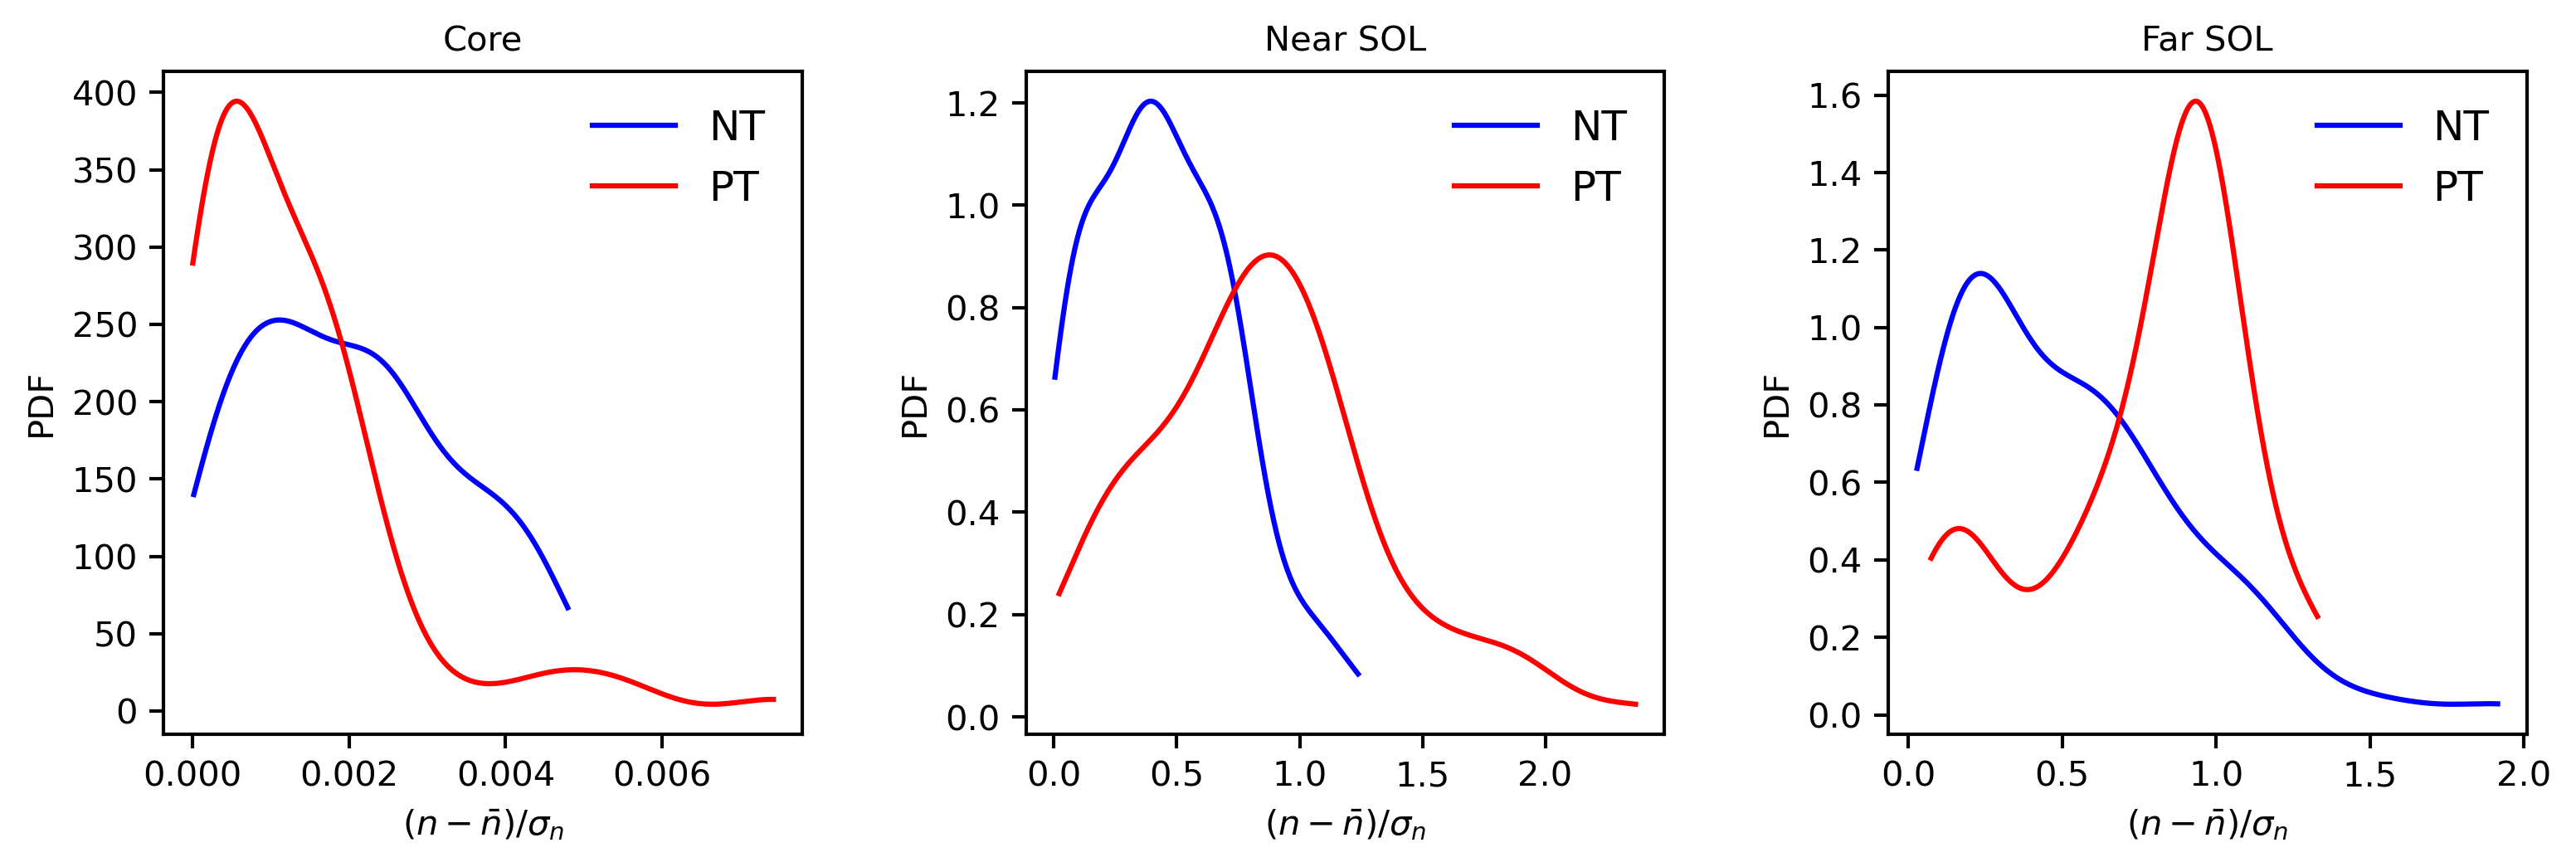

In [40]:
# Plotting PDFs
#plt.subfigure(ncols=3, figsize=(10, 7), dpi=100)
fig, axes = plt.subplots(ncols=3, figsize=(3.5*fig_width, 1.6*fig_height))

axes[0].plot(NT_x_grid_core, NT_PDF_core, c='b', label='NT')
axes[0].plot(PT_x_grid_core, PT_PDF_core, c='r', label='PT', ls='-')

axes[1].plot(NT_x_grid_near_SOL, NT_PDF_near_SOL, c='b', label='NT')
axes[1].plot(PT_x_grid_near_SOL, PT_PDF_near_SOL, c='r', label='PT', ls='-')

axes[2].plot(NT_x_grid_far_SOL, NT_PDF_far_SOL, c='b', label='NT')
axes[2].plot(PT_x_grid_far_SOL, PT_PDF_far_SOL, c='r', label='PT', ls='-')
#plot_pdf(dens_fluct_far_SOL, 'Far SOL')

for ax in axes:
    ax.set_xlabel(r'$(n - \bar{n})/\sigma_n$')
    ax.set_ylabel('PDF')

axes[0].set_title('Core')
axes[1].set_title('Near SOL')
axes[2].set_title('Far SOL')

axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right', facecolor='white', framealpha=0)
axes[1].legend(bbox_to_anchor=(1, 1), loc='upper right', facecolor='white', framealpha=0)
axes[2].legend(bbox_to_anchor=(1, 1), loc='upper right', facecolor='white', framealpha=0)

#plt.legend()
#plt.title('Density Fluctuation PDFs')
#plt.show()

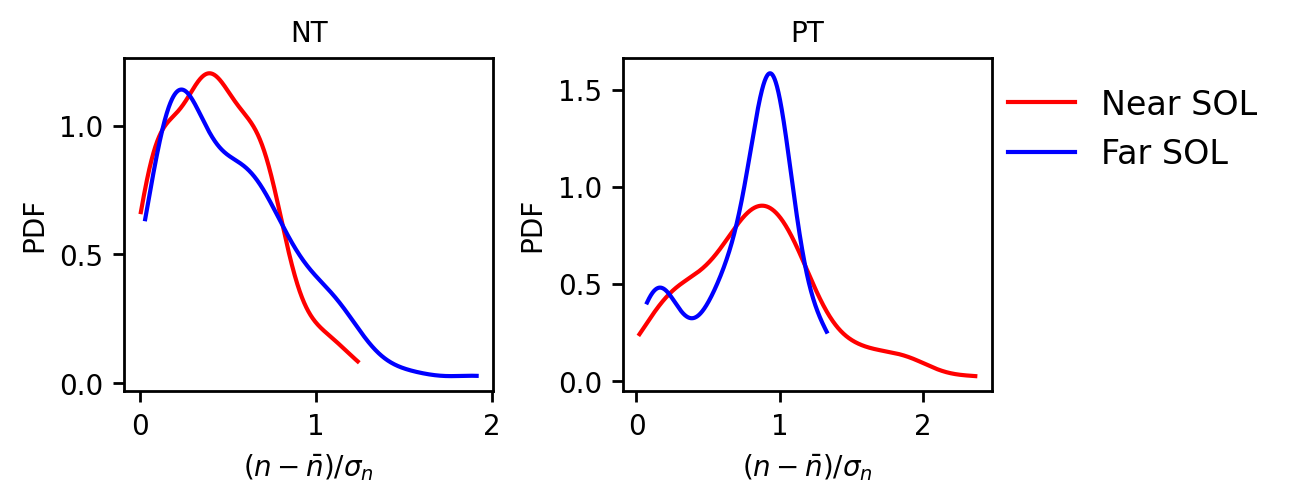

In [41]:
# Plotting PDFs
#plt.subfigure(ncols=3, figsize=(10, 7), dpi=100)
fig, axes = plt.subplots(ncols=2, figsize=(1.6*fig_width, fig_height), dpi=200)

#axes.plot(x_grid_core, PDF_core, c='k', label='Core')
axes[0].plot(NT_x_grid_near_SOL, NT_PDF_near_SOL, c='r', label='Near SOL')
axes[0].plot(NT_x_grid_far_SOL, NT_PDF_far_SOL, c='b', label='Far SOL')

axes[1].plot(PT_x_grid_near_SOL, PT_PDF_near_SOL, c='r', label='Near SOL')
axes[1].plot(PT_x_grid_far_SOL, PT_PDF_far_SOL, c='b', label='Far SOL')

#plot_pdf(dens_fluct_far_SOL, 'Far SOL')

axes[0].set_xlabel(r'$(n - \bar{n})/\sigma_n$')
axes[1].set_xlabel(r'$(n - \bar{n})/\sigma_n$')

axes[0].set_ylabel('PDF')
axes[1].set_ylabel('PDF')

axes[0].set_title('NT')
axes[1].set_title('PT')
#axes.set_title('PDF')

axes[1].legend(bbox_to_anchor=(1.8, 1), loc='upper right', facecolor='white', framealpha=0)
#plt.legend()